In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARW_pow2', None)
from ARW_pow2 import *

sys.modules.pop('plots', None)
from plots import *

In [2]:
def simulate(seed, num_periods, true_means, variance, B_arr, B_arr_tr, fixed_windows, num_trials, alpha, delta, gamma, next_period=False):

    np.random.seed(seed)

    #B_arr is for val set
    B_arr_ends = np.cumsum(B_arr) - 1
    B_arr_tr_ends = np.cumsum(B_arr_tr) - 1

    cdf_dict = create_empty_dict(fixed_windows, num_trials)

    seeds = np.arange(num_trials) + 2024

    for (trial, seed) in tqdm(enumerate(seeds)):
        
        np.random.seed(seed)
        U = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)
 
        for t in range(num_periods):
            
            mu_t = true_means[t]

            U_t = U[:B_arr_ends[t]+1]
            B_arr_t = B_arr[:t+1]

            khat, qt_khat, qtk_all = ARWQE(U_t, B_arr_t, alpha, delta, gamma)
            coverage_ARW = norm.cdf(qt_khat, mu_t, np.sqrt(variance))
            cdf_dict['ARW'][trial].append(coverage_ARW)
            
            #baseline: take quantile of fixed k
            for ik, k in enumerate(fixed_windows):
                log2k = int(np.log2(k))
                qtk = qtk_all[min(log2k, len(qtk_all)-1)]
                coverage_k = norm.cdf(qtk, mu_t, np.sqrt(variance))
                cdf_dict[f'Val_{k}'][trial].append(coverage_k)
    return cdf_dict

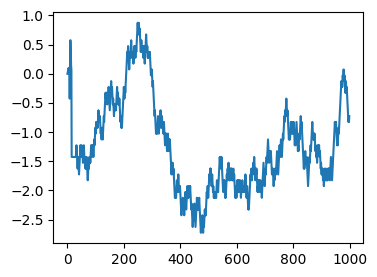

2it [00:01,  1.10it/s]


In [3]:
num_periods = 1000
seed = 6
np.random.seed(seed)
B_arr = np.random.randint(low=1, high=2, size=num_periods)
fixed_windows = [1, 4, 16, 64, 256, 1024]
num_trials = 2
variance = 1
alpha, delta, gamma = 0.1, 0.1, 1

#NOTE: change shift patterns
#true_means = 2 * np.sin(np.linspace(0, 3 * np.pi, 1000)) + 5
true_means = 5 * generate_true_means(num_periods-1, 2)
#true_means = 10 * np.ones(num_periods)

plt.figure(figsize=(4,3))
plt.plot(true_means)
plt.show()

#NOTE: change this to (not) predict for the next period instead
next_period = False

parameters = {
    "seed": seed,
    "num_periods": num_periods,
    "true_means": true_means,
    "B_arr": B_arr,
    "B_arr_tr": 3 * B_arr,  # This will be calculated based on B_arr
    "fixed_windows": fixed_windows,
    "num_trials": num_trials,
    "variance": variance, 
    "next_period": next_period,
    "alpha": alpha, "delta": delta, "gamma": gamma,
}

cdf_dict = simulate(**parameters)

mean_error [0.0770069  0.41112813 0.13906947 0.06991008 0.06919387 0.09653292
 0.09368126]
se_error [0.00204255 0.00299384 0.00676814 0.0074022  0.00751304 0.00683938
 0.00299204]


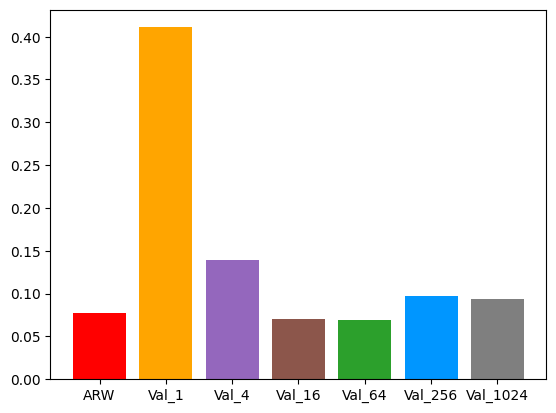

In [4]:
#process results in cdf_dict
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
cdf_array, err_array, mean_error, se_error = summarize_cdf_dict(methods, num_trials, num_periods, cdf_dict, alpha)
print('mean_error', mean_error)
print('se_error', se_error)

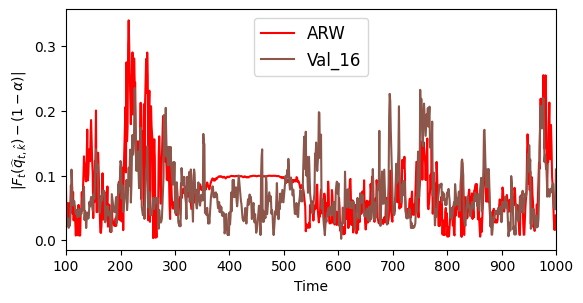

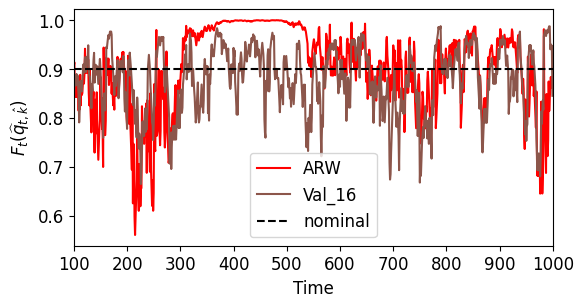

In [5]:
#plot cdf over time periods for ARW, V1, V256
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF', 'tab:gray']
methods = ['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']

#NOTE: uncomment to change the index of the methods to plot
methods_to_plot = [0, 3]

cdf_over_trials = np.mean(cdf_array[:, :, :], axis=1)
err_over_trials = np.mean(err_array[:, :, :], axis=1)

plot_over_time(colors, methods, 100, 1000, err_over_trials, methods_to_plot)
plot_over_time(colors, methods, 100, 1000, cdf_over_trials, methods_to_plot, alpha=0.1)
#uncomment to show legend and save the figure

plt.legend()
#plt.savefig(f'{DATAPATH}/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')
